# NFL Pass Play Analysis

This notebook explores the dataset given in the [NFL Big Data Bowl 2021 Kaggle competition](https://www.kaggle.com/c/nfl-big-data-bowl-2021/overview). The dataset used is NFL’s Next Gen Stats 2018 data, which includes comprehensive information on all plays and players for the entire 2018 season. We will be exploring the dataset to find any interesting insights, and we will then attempt to classify the pass result of a play based on the play's attributes.

## Import Libraries

We will be using the standard data science and machine learning libaries for Python such as pandas, numpy, and sci-kit learn.

In [21]:
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn
import seaborn as sns
from IPython.display import display, HTML

# Pandas options
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Seaborn options
sns.set_theme()

# Ignore warnings
warnings.filterwarnings("ignore")

# Variable that says whether or not we're on colab or not
IN_COLAB = 'google.colab' in str(get_ipython())

## Gather the Data

We have two datasets to work with. The dataset in `games.csv` has information on the games including where who was playing in each game and what time the games took place. This isn't really useful for teh classificaiton task, but we'll use it to create another feature. The `plays.csv` file has the main attributes we will use for classification.

In [22]:
prefix = 'drive/MyDrive/' if IN_COLAB else ''
nfl_game_data = pd.read_csv(prefix + 'data/games.csv')
nfl_play_data = pd.read_csv(prefix + 'data/plays.csv')

print('Play data:')
display(nfl_play_data.head())
print('\n\nGame data:')
display(nfl_game_data.head())

Play data:


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.000,4.000,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.000,0.000,15:00:00,90.000,NaN,NaN,C,10,10,0.262,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.000,4.000,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.000,0.000,13:10:00,49.000,NaN,NaN,I,0,0,-0.372,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.000,4.000,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.000,0.000,13:05:00,49.000,NaN,NaN,I,0,0,-0.703,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.000,5.000,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.000,0.000,13:01:00,49.000,NaN,NaN,C,33,33,3.048,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.000,6.000,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.000,0.000,10:59:00,11.000,NaN,NaN,I,0,0,-0.842,False




Game data:


,gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
0,2018090600,09/06/2018,20:20:00,PHI,ATL,1
1,2018090901,09/09/2018,13:00:00,CLE,PIT,1
2,2018090902,09/09/2018,13:00:00,IND,CIN,1
3,2018090903,09/09/2018,13:00:00,MIA,TEN,1
4,2018090900,09/09/2018,13:00:00,BAL,BUF,1


We will primarliy using the `nfl_play_data` dataframe for our classification task. The `nfl_game_data` will be used for some feature engineering with the play data, but subsequent analysis will focus on the game data. Let's look at the info on the dataframe.

In [23]:
nfl_play_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  19239 non-null  int64  
 1   playId                  19239 non-null  int64  
 2   playDescription         19239 non-null  object 
 3   quarter                 19239 non-null  int64  
 4   down                    19239 non-null  int64  
 5   yardsToGo               19239 non-null  int64  
 6   possessionTeam          19239 non-null  object 
 7   playType                19239 non-null  object 
 8   yardlineSide            18985 non-null  object 
 9   yardlineNumber          19239 non-null  int64  
 10  offenseFormation        19098 non-null  object 
 11  personnelO              19210 non-null  object 
 12  defendersInTheBox       19177 non-null  float64
 13  numberOfPassRushers     18606 non-null  float64
 14  personnelD              19210 non-null

## Data Cleaning

In this stage, we will clean our data by 1) completing missing information and dropping irrelevant attributes, 2) creating new features for analysis, and 3) converting fields to the correct format for calculations. We will create a copy of the dataset for cleaning and go from there.

In [24]:
nfl_plays = nfl_play_data.copy(deep=True)

### Completing

Examine the null values in the columns.

In [25]:
nfl_plays.isnull().sum()

gameId                        0
playId                        0
playDescription               0
quarter                       0
down                          0
yardsToGo                     0
possessionTeam                0
playType                      0
yardlineSide                254
yardlineNumber                0
offenseFormation            141
personnelO                   29
defendersInTheBox            62
numberOfPassRushers         633
personnelD                   29
typeDropback                639
preSnapVisitorScore         639
preSnapHomeScore            639
gameClock                   639
absoluteYardlineNumber      639
penaltyCodes              18033
penaltyJerseyNumbers      18033
passResult                    2
offensePlayResult             0
playResult                    0
epa                           0
isDefensivePI                 0
dtype: int64

 There are many null values in the penalty fields. However, this is to be expected since there are not penalties on every play. We will eventually drop these columns anyway. There are quite a few null values in the remaining attributes. This could be because the values are actually zero (for instance, the pre-snap scores would be 0 at the beginning of a game) or because of a typo. Let's examine the different pre-snap values.

In [26]:
nfl_plays.preSnapHomeScore.value_counts()[:10]

0.000     3758
7.000     2341
14.000    1432
10.000    1318
Name: preSnapHomeScore, dtype: int64

Since there are 0s in the dataset, we can assume that the null values are mistakes in the category. Similar results can be found with the other columns. Since there are quite a few instances with null attributes, we will do some data imputation and fill in the null values. Before we begin, we will remove the instances with nulls in the `passResult` attribute since this is our target variable for classification.

In [27]:
nfl_plays = nfl_plays.dropna(subset=['passResult'])

Now we'll fill in null values in the remaining attributes.

In [28]:
# Impute the columns with missing data
nfl_plays['playType'].fillna(nfl_plays['playType'].mode()[0], inplace=True)
nfl_plays['offenseFormation'].fillna(nfl_plays['offenseFormation'].mode()[0], inplace=True)
nfl_plays['personnelO'].fillna(nfl_plays['personnelO'].mode()[0], inplace=True)
nfl_plays['personnelD'].fillna(nfl_plays['personnelO'].mode()[0], inplace=True)
nfl_plays['typeDropback'].fillna(nfl_plays['typeDropback'].mode()[0], inplace=True)
nfl_plays['numberOfPassRushers'].fillna(nfl_plays['numberOfPassRushers'].median(), inplace=True)
nfl_plays['preSnapVisitorScore'].fillna(nfl_plays['preSnapVisitorScore'].median(), inplace=True)
nfl_plays['preSnapHomeScore'].fillna(nfl_plays['preSnapHomeScore'].median(), inplace=True)
nfl_plays['isDefensivePI'].fillna(nfl_plays['isDefensivePI'].mode(), inplace=True)
nfl_plays['defendersInTheBox'].fillna(nfl_plays['defendersInTheBox'].median(), inplace=True)
nfl_plays['absoluteYardlineNumber'].fillna(nfl_plays['absoluteYardlineNumber'].median(), inplace=True)

Let's examine the pass result column to ensure we have all possible results. There should be 4 according to the Kaggle overview: "C" for complete, "I" for incomplete, "IN" for interception, and "S" for sack.

In [29]:
# View class distribution for pass result
nfl_plays.passResult.value_counts()

C     11370
I      6135
S      1308
IN      420
R         4
Name: passResult, dtype: int64

There are 4 instances of a mysterious "R" class. We will remove this since it is a mistake and there are no that many instances with this class.

In [30]:
# Remove "R" class
nfl_plays = nfl_plays[nfl_plays.passResult != 'R']

### Feature Engineering

We will attempt to create new features to use for classification. Three features that would seem useful to us is (1) whether or not the team with possession of the ball is the home team, (2) whether or not the possession team is ahead or behind, and (3) whether the game clock is under two minutes. We will cross reference the nfl games dataset to determine this.

In [31]:
# Cross-reference the games data to see who (home or visitor) has posession of the ball for each play
temp_df = pd.DataFrame()
for i, game in nfl_game_data.iterrows():
    plays = nfl_plays[game.gameId == nfl_plays.gameId]
    plays['possessionTeamIsHome'] = (plays.possessionTeam == game.homeTeamAbbr).astype(int)
    temp_df = temp_df.append(plays)
    
nfl_plays = temp_df

In [32]:
# Add attribute of whether the possession team is ahead
nfl_plays['possessionTeamAhead'] = (nfl_plays['possessionTeamIsHome'] & (nfl_plays['preSnapHomeScore'] > nfl_plays['preSnapVisitorScore'])) | \
                                    ((~nfl_plays['possessionTeamIsHome']) & (nfl_plays['preSnapVisitorScore'] > nfl_plays['preSnapHomeScore']))

nfl_plays['possessionTeamAhead'] = nfl_plays['possessionTeamAhead'].astype(int)

In [33]:
# Add game clock column under 2 minutes
def is_under_minutes(mins=2):
    def _is_under(x: str) -> bool:
        if pd.isna(x):
            return False
        num_rep = int("".join(filter(str.isdigit, x)))
        return num_rep <= mins*10000
    return _is_under

nfl_plays['under2mins'] = nfl_plays['gameClock'].apply(is_under_minutes(2)).astype(int)

Lastly, we'll drop the irrelevant columns for our prediction task

In [34]:
# Drop irrelevant columns
nfl_plays = nfl_plays.drop(columns=[
    'gameId', 
    'playId', 
    'playDescription',
    'possessionTeam', 
    'yardlineNumber', 
    'yardlineSide',
    'penaltyJerseyNumbers',
    'penaltyCodes',
    'gameClock'
])

### Data Conversion

We will be converting nominal attributes to dummy variable for mathematical analysis. Later, these will be changed to one-hot encoded vectors because there is no inherent order among the nominal attributes.

In [35]:
nominal_attrs = [
    'playType', 
    'offenseFormation', 
    'personnelO', 
    'personnelD', 
    'typeDropback', 
    'passResult'
]

# Encode the nominal attributes
nominal_labels = {} # Store the labels found
for attr in nominal_attrs:
    nfl_plays[attr], uniques = pd.factorize(nfl_plays[attr])
    nominal_labels[attr] = uniques

Let's do one last check to ensure all nulls are removed and the data looks like we want it.

In [36]:
nfl_plays.isnull().sum()

quarter                   0
down                      0
yardsToGo                 0
playType                  0
offenseFormation          0
personnelO                0
defendersInTheBox         0
numberOfPassRushers       0
personnelD                0
typeDropback              0
preSnapVisitorScore       0
preSnapHomeScore          0
absoluteYardlineNumber    0
passResult                0
offensePlayResult         0
playResult                0
epa                       0
isDefensivePI             0
possessionTeamIsHome      0
possessionTeamAhead       0
under2mins                0
dtype: int64

In [37]:
nfl_plays.head()

,quarter,down,yardsToGo,playType,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,passResult,offensePlayResult,playResult,epa,isDefensivePI,possessionTeamIsHome,possessionTeamAhead,under2mins
0,1,1,15,0,0,0,7.000,4.000,0,0,0.000,0.000,90.000,0,10,10,0.262,False,0,0,0
1,1,1,10,0,1,1,7.000,4.000,0,0,0.000,0.000,49.000,1,0,0,-0.372,False,0,0,0
2,1,2,10,0,2,0,6.000,4.000,0,0,0.000,0.000,49.000,1,0,0,-0.703,False,0,0,0
3,1,3,10,0,2,1,6.000,5.000,1,1,0.000,0.000,49.000,0,33,33,3.048,False,0,0,0
4,1,3,1,0,2,2,8.000,6.000,2,0,0.000,0.000,11.000,1,0,0,-0.842,False,0,0,0


In [38]:
nfl_plays.shape

(19233, 21)

After this data processing, we have a dataset with 19,233 entries and 21 attributes.

## Exploratory Data Analysis

Now that our data is cleaned, we will explore our data with descriptive and graphical statistics to describe and summarize our variables. First, let's examine the class distribution for `passResult`.

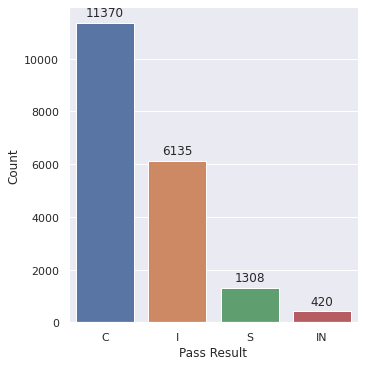

In [39]:
splot = sns.catplot(data=nfl_plays, x='passResult', kind='count').set(xlabel='Pass Result', ylabel='Count')
splot.set_xticklabels(nominal_labels['passResult'])
for ax in splot.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '2d'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

We have a skewed dataset with respect to the pass results. Approximately 59% of the dataset is complete passes, 32% is incompletes, 6.8% is sacks, and 2.2% is interceptions. We will have to take this into account for our classifier. In order to get a sense of correlated attributes, let's examine the correlation matrix of the attributes.

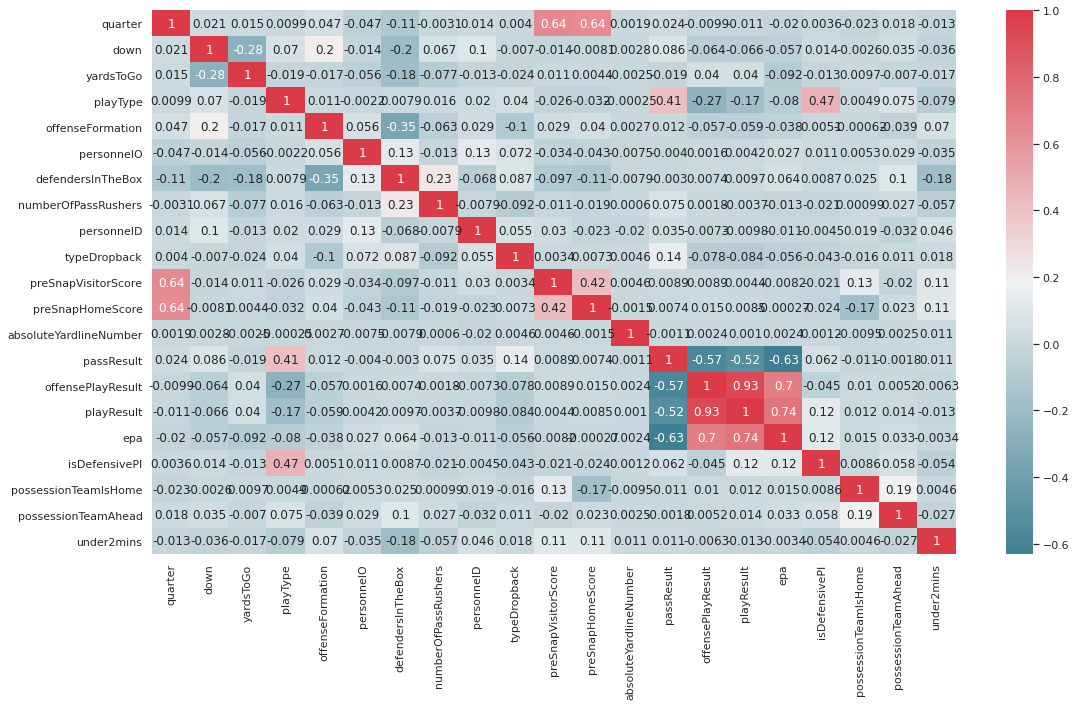

In [40]:
# Plot heatmap which shows correlations
plt.figure(figsize=(18, 10)) 
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(nfl_plays.corr(), annot=True, cmap=colormap)
plt.show()

As can be seen, not many of the attributes are stronly correlated with each other besides the EPA, play result, and offensive play result, which are all casula metrics that are taken after the play and cannot be used for classifiecation. Let's specifically see the correlation between the attributes and our target variable `passResult`:

In [41]:
nfl_plays.corr()['passResult']

quarter                   0.024
down                      0.086
yardsToGo                -0.019
playType                  0.413
offenseFormation          0.012
personnelO               -0.004
defendersInTheBox        -0.003
numberOfPassRushers       0.075
personnelD                0.035
typeDropback              0.142
preSnapVisitorScore       0.009
preSnapHomeScore          0.007
absoluteYardlineNumber   -0.001
passResult                1.000
offensePlayResult        -0.570
playResult               -0.525
epa                      -0.630
isDefensivePI             0.062
possessionTeamIsHome     -0.011
possessionTeamAhead      -0.002
under2mins                0.011
Name: passResult, dtype: float64

Create some violin plots to see the differences in distribution between each class.

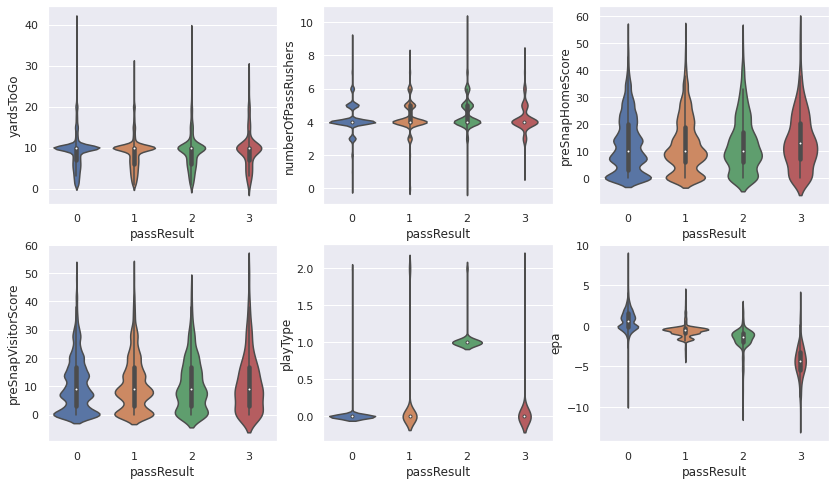

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
sns.violinplot(data=nfl_plays, x='passResult', y='yardsToGo', ax=axes[0][0])
sns.violinplot(data=nfl_plays, x='passResult', y='numberOfPassRushers', ax=axes[0][1])
sns.violinplot(data=nfl_plays, x='passResult', y='preSnapHomeScore', ax=axes[0][2])
sns.violinplot(data=nfl_plays, x='passResult', y='preSnapVisitorScore', ax=axes[1][0])
sns.violinplot(data=nfl_plays, x='passResult', y='playType', ax=axes[1][1])
sns.violinplot(data=nfl_plays, x='passResult', y='epa', ax=axes[1][2])
plt.show()

Next, we will perform some statistical tests on the data. Here are a few theories we are making about the attributes and their relationship with `passResult`:

* `yardsToGo`: The higher the yards to go, the more likely a pass will complete

* `defendersInTheBox`: The higher the number of defenders in the box, the higher the chance of a completion

* `numberOfPassRushers`: The higher the number of pass rushers, the lower the chance of completion

* `absoluteYardLineNumber`: The highe the absolute yard line, the higher the chance of a completion

* `under2mins`: If the game clock is under 2 minutes, the lower the chance of a completion

We use the $\chi^2$-test for independence to determine whether there is an assocation between two categorical variables. The `scipy` library has a function that does this test called `chi2_contingency`. The second value returned from this function is the $p$-value. If the $p$-value is less than 0.05, we reject the null hypothesis that the two attributes are not associated.

In [43]:
from scipy.stats import chi2_contingency

print('Chi-squared                p-values                       p > 0.05')
print('-'*70)
attrs = nominal_attrs + ['under2mins', 'possessionTeamAhead', 'possessionTeamIsHome']
for attr in attrs:
        pval = chi2_contingency(pd.crosstab(nfl_plays.passResult, nfl_plays[attr]))[1]
        print(f'{attr.ljust(25)}:', str(pval).ljust(30), pval > 0.05)

Chi-squared                p-values                       p > 0.05
----------------------------------------------------------------------
playType                 : 0.0                            False
offenseFormation         : 0.002472883024789699           False
personnelO               : 0.1749937486268864             True
personnelD               : 0.0023466502238329865          False
typeDropback             : 0.0                            False
passResult               : 0.0                            False
under2mins               : 0.05383197269911015            True
possessionTeamAhead      : 0.6223945685113232             True
possessionTeamIsHome     : 0.45544267783354164            True


Another test we can do is the One-way Anova test to determine whether there are any statistically significant differences between the means of 3 or more groups. We use `scipy`'s `f_oneway` function to perform this test with the 4 pass results. If the $p$-value is below 0.05, we can reject the null hypothesis that the means are the same and conclude that they are different.

In [44]:
from scipy.stats import f_oneway

print('One-way Anova             p-values                       p > 0.05')
print('-'*70)
F, p = f_oneway(
    nfl_plays[nfl_plays['passResult'] == 0], 
    nfl_plays[nfl_plays['passResult'] == 1],
    nfl_plays[nfl_plays['passResult'] == 2],
    nfl_plays[nfl_plays['passResult'] == 3]
)
for i in range(len(nfl_plays.columns)):
    print(f'{nfl_plays.columns[i].ljust(25)}: {str(p[i]).ljust(30)} {p[i] > 0.05}')

One-way Anova             p-values                       p > 0.05
----------------------------------------------------------------------
quarter                  : 0.00532814290528861            False
down                     : 1.913366533143383e-42          False
yardsToGo                : 5.896006678429017e-09          False
playType                 : 0.0                            False
offenseFormation         : 0.2489747568850808             True
personnelO               : 0.7577925096811365             True
defendersInTheBox        : 2.5840085683290588e-05         False
numberOfPassRushers      : 6.595159430384663e-37          False
personnelD               : 1.0419972930652855e-05         False
typeDropback             : 7.829331805071367e-144         False
preSnapVisitorScore      : 0.5636683674329215             True
preSnapHomeScore         : 0.056240867127263776           True
absoluteYardlineNumber   : 0.9812057661453063             True
passResult               : 0.0      

## Further Data Processing for Classification

Before we proceed any further, we need to do some more cleaning on the data that we weren't able to perform for data exploration for the sake of readability.

### Remove Irrelevant/Causal attributes
Pull out the EPA, playResult, offensivePlayResult, and playType, which should not be used for classification since they are recorded after the result of a play.

In [45]:
causal_attrs = ['epa', 'playResult', 'offensePlayResult', 'playType', 'isDefensivePI']
nfl_plays = nfl_plays.drop(columns=causal_attrs)

### One-Hot Encode Nominal attributes
For the attributes that are nominal, we will convert their values into one-hot encoded vectors; that is, we will create features of asymmetric binary attributes for each category. We do this because there is no inherent order associated with the attributes, and we do not want the classifiers to believe there is.

In [46]:
from sklearn.preprocessing import OneHotEncoder

nominal_class_attrs = [
    'offenseFormation', 
    'personnelO', 
    'personnelD', 
    'typeDropback'
]

# Transform the nominal attributes
for attr in nominal_class_attrs:
    ohe = OneHotEncoder()
    attr_feature_arr = ohe.fit_transform(nfl_plays[[attr]]).toarray()
    attr_labels = [f'{attr}_{l}' for l in list(nominal_labels[attr])]
    attr_features = pd.DataFrame(attr_feature_arr, columns=attr_labels)
    attr_features.reset_index(drop=True, inplace=True)
    nfl_plays.reset_index(drop=True, inplace=True)
    nfl_plays = pd.concat([nfl_plays, attr_features], axis=1)
    
# Drop the original nominal attributes
nfl_plays = nfl_plays.drop(columns=nominal_class_attrs)

### Scale Continuous Attributes
Scale the continuous-valued attributes using sklearn's `StandardScaler`

In [47]:
from sklearn.preprocessing import RobustScaler, StandardScaler

continuous_attrs = [
    'quarter', 
    'down', 
    'yardsToGo', 
    'defendersInTheBox', 
    'numberOfPassRushers',
    'preSnapVisitorScore',
    'preSnapHomeScore',
    'absoluteYardlineNumber'
]

scaler = StandardScaler()
nfl_plays[continuous_attrs] = scaler.fit_transform(nfl_plays[continuous_attrs])

### Train-Test Split

Perform a train-test split since we are done with cleaning the data.

In [49]:
from sklearn.model_selection import train_test_split

X = nfl_plays.drop(columns=['passResult'])
y = nfl_plays['passResult'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (17309, 138)
Test: (1924, 138)


### Feature selection

To select the most important features, we will use sklearn's feature selection suite to find the best subset of features. We will use a decision tree classifier for this because it can handle attributes of various types well and trains very fast. ***We are using the training dataset to select features only.***

In [60]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

nfl_plays_X = nfl_plays.drop(columns=['passResult'])
nfl_plays_y = nfl_plays.passResult.to_numpy()

estimator = LinearSVC()
selector = RFE(estimator, n_features_to_select=100, step=1, verbose=2)
selector = selector.fit(X_train, y_train)

Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
F

In [61]:
selector.n_features_

100

In [62]:
nfl_plays_X.columns[~selector.support_]

Index(['quarter', 'down', 'yardsToGo', 'defendersInTheBox',
       'numberOfPassRushers', 'preSnapVisitorScore', 'preSnapHomeScore',
       'absoluteYardlineNumber', 'possessionTeamIsHome', 'possessionTeamAhead',
       'under2mins', 'offenseFormation_EMPTY', 'personnelO_2 RB, 1 TE, 2 WR',
       'personnelO_1 RB, 1 TE, 3 WR', 'personnelO_1 RB, 2 TE, 2 WR',
       'personnelO_1 RB, 3 TE, 1 WR', 'personnelO_2 RB, 0 TE, 3 WR',
       'personnelO_0 RB, 1 TE, 4 WR', 'personnelO_1 RB, 0 TE, 4 WR',
       'personnelO_6 OL, 1 RB, 2 TE, 1 WR',
       'personnelO_6 OL, 2 RB, 0 TE, 2 WR',
       'personnelO_1 RB, 1 TE, 2 WR,1 P,3 LB,1 LS,2 DB',
       'personnelO_1 RB, 0 TE, 0 WR,1 P,3 LB,1 LS,1 DL,4 DB',
       'personnelD_4 DL, 2 LB, 5 DB', 'personnelD_4 DL, 1 LB, 6 DB',
       'personnelD_3 DL, 3 LB, 5 DB', 'personnelD_4 DL, 3 LB, 4 DB',
       'personnelD_3 DL, 4 LB, 4 DB', 'personnelD_2 DL, 3 LB, 6 DB',
       'personnelD_2 DL, 4 LB, 5 DB', 'personnelD_3 DL, 2 LB, 6 DB',
       'personnelD_

As can be seen above, most of the features to eliminate are frome the offensive and defensive personel attributes. This makes sense because the attributes are part of the one-hot encoding of the different personel, and there are a large number of values these variables can take on. Let's then use this subset for classification.

In [63]:
X_train = X_train[nfl_plays_X.columns[selector.support_]]
X_test = X_test[nfl_plays_X.columns[selector.support_]]
X_train.shape, X_test.shape

((17309, 100), (1924, 100))

Hence, we now have a dataset that should be better suited for classificaion tasks

## Classification

First, we will get some baseline results to compare with our classifiers.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

def print_scores(y_pred, y_test):
    print('Summary')
    print('-'*60)
    print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
    print(f'Precision: {precision_score(y_pred, y_test, average="weighted")}')
    print(f'Recall: {recall_score(y_pred, y_test, average="weighted")}')
    print(f'F1 Score: {f1_score(y_pred, y_test, average="weighted")}')

In [ ]:
from sklearn.dummy import DummyClassifier

for strategy in ['stratified', 'most_frequent', 'uniform', 'prior']:
    dc = DummyClassifier(strategy=strategy)
    dc.fit(X_train, y_train)
    print_scores(y_test, dc.predict(X_test))

We will now test out numerous classifiers. The following cell inludes a list called `MLA` of classifiers and their parameter grid that will be used for `GridSearchCV`, which will run an exhaustive search over the parameter values for the estimator.

In [76]:
from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, \
                    neighbors, svm, tree, discriminant_analysis, neural_network
from xgboost import XGBClassifier

#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # MLP
    {
        'alg': neural_network.MLPClassifier(),
        'params': {
            'hidden_layer_sizes': [(100,), (100, 50, 2)],
            'activation': ['relu', 'logistic']
        }
    },
    
    # SVM
    {
        'alg': svm.LinearSVC(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l2']
        }
    },
    {
        'alg': svm.SVC(probability=True),
        'params': {
            'kernel': ['poly', 'rbf']
        }
    },

    # Linear models
    {
        'alg': linear_model.LogisticRegression(n_jobs=-1),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'max_iter': [300, 1000, 3000]
        }
    },
    {
        'alg': linear_model.PassiveAggressiveClassifier(n_jobs=-1),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'max_iter': [300, 1000, 3000]
        }
    },
    {
        'alg': linear_model.RidgeClassifierCV(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    {
        'alg': linear_model.SGDClassifier(),
        'params': {
            'loss': ['log', 'modified_huber', 'squared_epsilon_insensitive'],
            'penalty': ['l2', 'elasticnet']
        }
    },
    {
        'alg': linear_model.Perceptron(n_jobs=-1),
        'params': {
            'penalty': ['l2', 'elasticnet'],
            'max_iter': [1000, 3000]
        }
    },

    # Ensemble Methods
    {
        'alg': ensemble.AdaBoostClassifier(),
        'params': {
            'n_estimators': [5, 50, 100],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    {
        'alg': ensemble.BaggingClassifier(),
        'params': {
            'n_estimators': [5, 50, 100],
            'max_samples': [0.1, 0.5, 1.0]
        }
    },
    {
        'alg': ensemble.ExtraTreesClassifier(),
        'params': {
            'n_estimators': [5, 50, 100],
            'max_depth': [5, 10, 15, None]
        }
    },
    {
        'alg': ensemble.GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.01],
            'n_estimators': [100, 300],
            'max_depth': [10, 20]
        }
    },
    {
        'alg': ensemble.RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 300],
            'max_depth': [10, 15, 20]
        }
    },

    # Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),
    
    # Navies Bayes
    {
        'alg': naive_bayes.BernoulliNB(),
        'params': {
            'binarize': [-1, -0.5, 0, 0.5, 1]
        }
    },
    {
        'alg': naive_bayes.GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-6, 1e-3]
        }
    },
    
    # Nearest Neighbor
    {
        'alg': neighbors.KNeighborsClassifier(),
        'params': {
            'n_neighbors': [2, 4, 6],
            'weights': ['uniform', 'distance']
        }
    },
    
    # Trees
    {
        'alg': tree.DecisionTreeClassifier(),
        'params': {
            'max_depth': list(range(1, 30)) + [None],
            'max_features': [10, 20, 30, 40, 50, 75, 100, None]
        }
    },
    {
        'alg': tree.ExtraTreeClassifier(),
        'params': {
            'max_depth': list(range(1, 10)) + [None],
            'min_samples_split': [0.01, 0.05, 0.1, 0.2, 2]
        }
    },
    
    # Discriminant Analysis
    {
        'alg': discriminant_analysis.LinearDiscriminantAnalysis(),
        'params': {
            'n_components': [50, 100, None]
        }
    },
    {
        'alg': discriminant_analysis.QuadraticDiscriminantAnalysis(),
        'params': {
            'reg_param': [0, 0.1, 1]
        }
    },

    # XGB
    {
        'alg': XGBClassifier(),
        'params': {
            'learning_rate': [.25], 
            'max_depth': [20], 
            'n_estimators': [100, 150], 
            'booster': ['gblinear']
        }
    },
]

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# Create table to compare MLA predictions
MLA_predict = pd.DataFrame({'passResult': y_test})

# Set the scores to track with cross validation
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Index through MLA and save performance to table
row_index = 0
for candidate in MLA:
    # Set name and parameters
    MLA_name = candidate['alg'].__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(candidate['alg'].get_params())
    
    # Score model with cross validation
    print(f'Beginning {MLA_name}')
    clf = GridSearchCV(
        candidate['alg'], 
        candidate['params'],
        n_jobs=-1,
        return_train_score=True,
        scoring=scoring,
        cv=3,
        refit='accuracy',
        verbose=2
    )
    clf.fit(X_train, y_train)

    MLA_compare.loc[row_index, 'MLA Time'] = clf.cv_results_['mean_fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = clf.cv_results_['mean_train_accuracy'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = clf.cv_results_['mean_test_accuracy'].mean()
    MLA_compare.loc[row_index, 'MLA Test Precision Mean'] = clf.cv_results_['mean_test_precision_weighted'].mean()  
    MLA_compare.loc[row_index, 'MLA Test Recall Mean'] = clf.cv_results_['mean_test_recall_weighted'].mean()  
    MLA_compare.loc[row_index, 'MLA Test F1 Score Mean'] = clf.cv_results_['mean_test_f1_weighted'].mean()  

    # If this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = clf.cv_results_['mean_test_accuracy'].std()*3

    # Validation on test set
    y_pred = clf.predict(X_test)
    MLA_compare.loc[row_index, 'MLA Validation Accuracy'] = accuracy_score(y_test, y_pred)

    # Save MLA predictions
    MLA_predict[MLA_name] = y_pred

    print(f'Finished {MLA_name} with train acc of {clf.cv_results_["mean_train_accuracy"].mean()} and test acc of {clf.cv_results_["mean_test_accuracy"].mean()}')
    print('-'*70, '\n')
    
    row_index+=1

  
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)

Beginning MLPClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.6min finished


Finished MLPClassifier with train acc of 0.60391991787928 and test acc of 0.5969582237940008
---------------------------------------------------------------------- 

Beginning LinearSVC
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.1s finished


Finished LinearSVC with train acc of 0.6012421397226766 and test acc of 0.5983361477343746
---------------------------------------------------------------------- 

Beginning SVC
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  7.9min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 14.8min finished


Finished SVC with train acc of 0.6104194480937702 and test acc of 0.6015945101505196
---------------------------------------------------------------------- 

Beginning LogisticRegression
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   37.7s finished


Finished LogisticRegression with train acc of 0.5996244804936255 and test acc of 0.5973077148902761
---------------------------------------------------------------------- 

Beginning PassiveAggressiveClassifier
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.7s finished


Finished PassiveAggressiveClassifier with train acc of 0.542844774092839 and test acc of 0.5401236413793158
---------------------------------------------------------------------- 

Beginning RidgeClassifierCV
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.4s finished


Finished RidgeClassifierCV with train acc of 0.6027211462656294 and test acc of 0.6008435993130078
---------------------------------------------------------------------- 

Beginning SGDClassifier
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.3min finished


Finished SGDClassifier with train acc of 0.5296813219452673 and test acc of 0.5266524095715738
---------------------------------------------------------------------- 

Beginning Perceptron
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.0s finished


Finished Perceptron with train acc of 0.3443010664509063 and test acc of 0.34623508645333295
---------------------------------------------------------------------- 

Beginning AdaBoostClassifier
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   26.7s finished


Finished AdaBoostClassifier with train acc of 0.5939010566181281 and test acc of 0.5931725052984831
---------------------------------------------------------------------- 

Beginning BaggingClassifier
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   43.9s finished


Finished BaggingClassifier with train acc of 0.6086718024964898 and test acc of 0.5995981140570055
---------------------------------------------------------------------- 

Beginning ExtraTreesClassifier
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   21.3s finished


Finished ExtraTreesClassifier with train acc of 0.6057686892000499 and test acc of 0.5984121891353605
---------------------------------------------------------------------- 

Beginning GradientBoostingClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.9min finished


Finished GradientBoostingClassifier with train acc of 0.6097189565199455 and test acc of 0.5989368889217344
---------------------------------------------------------------------- 

Beginning RandomForestClassifier
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   47.7s finished


Finished RandomForestClassifier with train acc of 0.6088996828050114 and test acc of 0.6004583564389712
---------------------------------------------------------------------- 

Beginning BernoulliNB
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Finished BernoulliNB with train acc of 0.5940377883077954 and test acc of 0.5928592361872791
---------------------------------------------------------------------- 

Beginning GaussianNB
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.3s finished


Finished GaussianNB with train acc of 0.04679644265037963 and test acc of 0.042579155634291356
---------------------------------------------------------------------- 

Beginning KNeighborsClassifier
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.0min finished


Finished KNeighborsClassifier with train acc of 0.5923750555868212 and test acc of 0.5857836814274933
---------------------------------------------------------------------- 

Beginning DecisionTreeClassifier
Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   43.8s finished


Finished DecisionTreeClassifier with train acc of 0.6070239327330332 and test acc of 0.5993767539937107
---------------------------------------------------------------------- 

Beginning ExtraTreeClassifier
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   10.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.5s finished


Finished ExtraTreeClassifier with train acc of 0.5948737618472085 and test acc of 0.5934393150345695
---------------------------------------------------------------------- 

Beginning LinearDiscriminantAnalysis
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.5s finished


Finished LinearDiscriminantAnalysis with train acc of nan and test acc of nan
---------------------------------------------------------------------- 

Beginning QuadraticDiscriminantAnalysis
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    2.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.1s finished


Finished QuadraticDiscriminantAnalysis with train acc of 0.4067633501450143 and test acc of 0.405049482420917
---------------------------------------------------------------------- 

Beginning XGBClassifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   13.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   29.6s finished


[19:34:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Finished XGBClassifier with train acc of 0.6044109973115561 and test acc of 0.6000924681701306
---------------------------------------------------------------------- 



In [78]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,MLA Test Precision Mean,MLA Test Recall Mean,MLA Test F1 Score Mean,MLA Validation Accuracy
2,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.610,0.602,0.003,383.263,0.554,0.602,0.512,0.613
5,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.603,0.601,0.000,0.562,0.553,0.601,0.515,0.613
12,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.609,0.600,0.005,4.841,0.554,0.600,0.502,0.612
20,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.604,0.600,0.000,14.857,0.550,0.600,0.518,0.609
9,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.609,0.600,0.009,4.077,0.549,0.600,0.512,0.615
16,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.607,0.599,0.009,0.106,0.544,0.599,0.506,0.613
11,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.610,0.599,0.007,135.643,0.547,0.599,0.499,0.613
10,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.606,0.598,0.010,1.549,0.566,0.598,0.489,0.613
1,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.601,0.598,0.011,1.889,0.551,0.598,0.503,0.612
3,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.600,0.597,0.012,2.484,0.505,0.597,0.492,0.609


Text(0, 0.5, 'Algorithm')

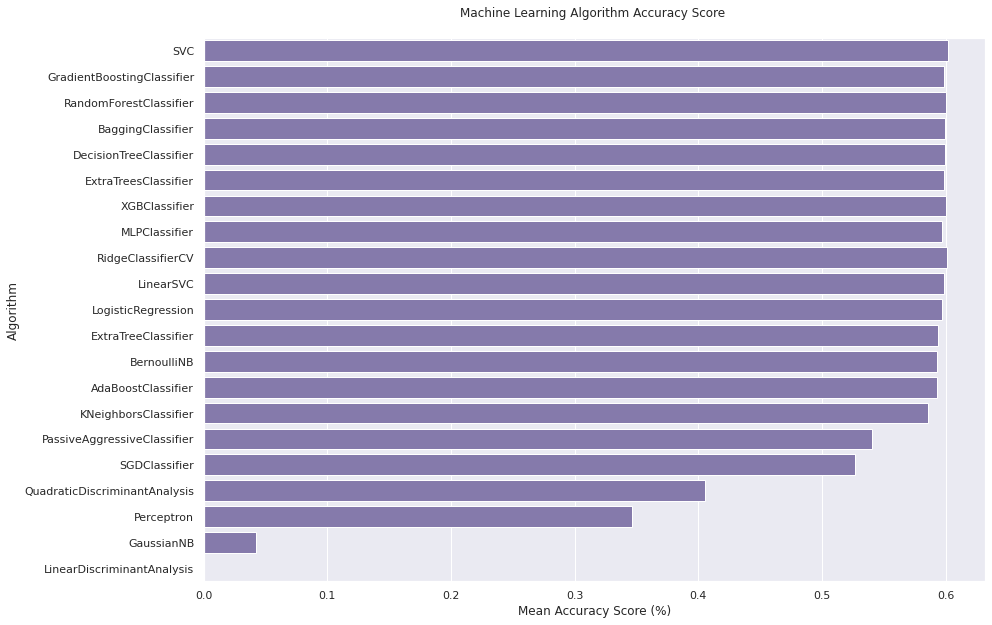

In [83]:
plt.figure(figsize=(14, 10))
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Mean Accuracy Score (%)')
plt.ylabel('Algorithm')

Text(0, 0.5, 'Algorithm')

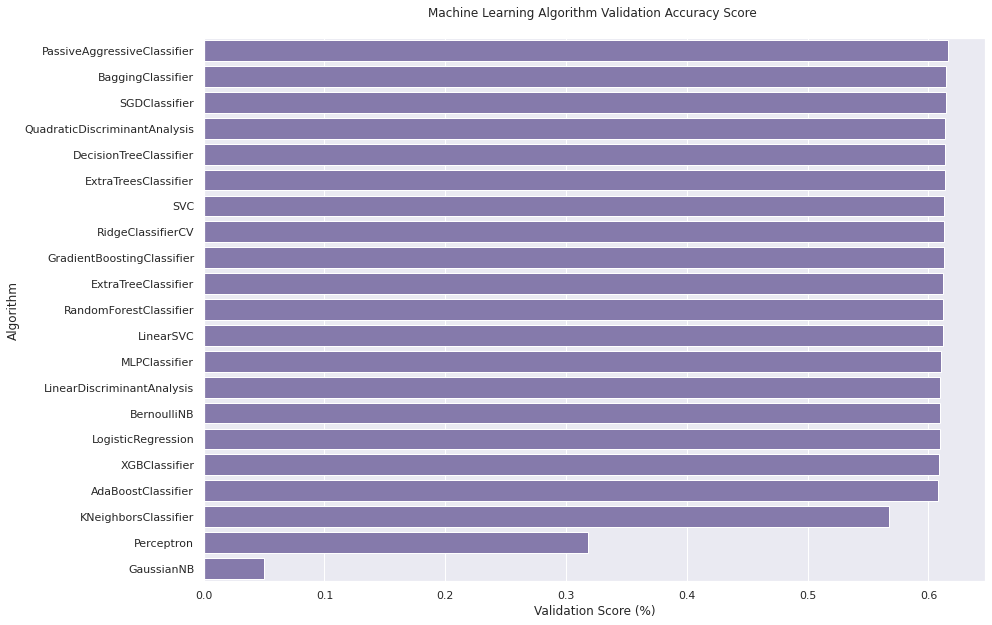

In [84]:
MLA_compare.sort_values(by=['MLA Validation Accuracy'], ascending=False, inplace=True)
plt.figure(figsize=(14, 10))
sns.barplot(x='MLA Validation Accuracy', y='MLA Name', data=MLA_compare, color='m')

plt.title('Machine Learning Algorithm Validation Accuracy Score \n')
plt.xlabel('Validation Score (%)')
plt.ylabel('Algorithm')

In [116]:
MLA_compare.iloc[0]['MLA Parameters']

"{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"

Text(0, 0.5, 'Algorithm')

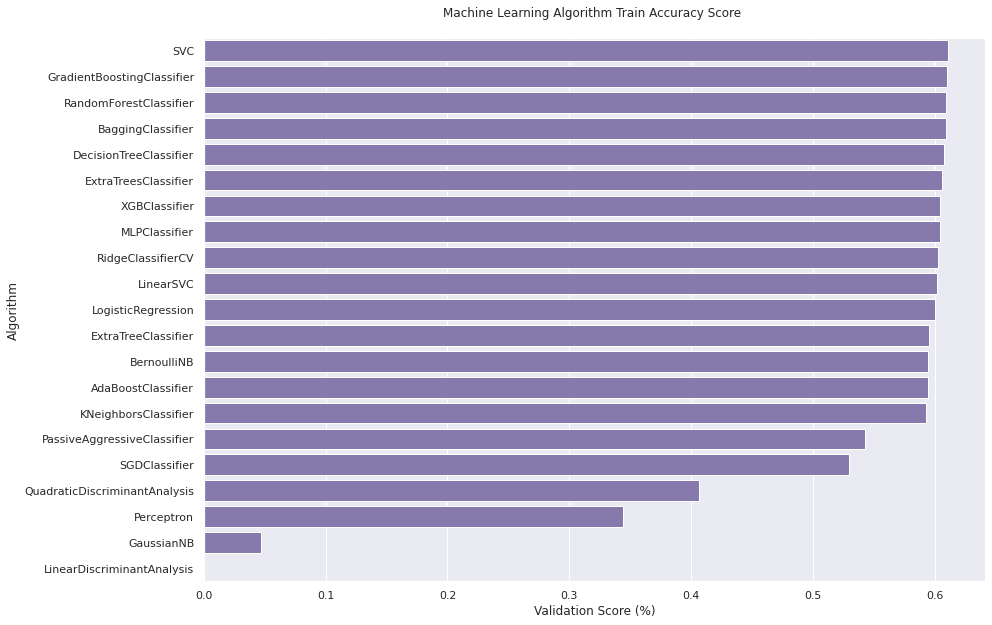

In [85]:
MLA_compare.sort_values(by=['MLA Train Accuracy Mean'], ascending=False, inplace=True)
plt.figure(figsize=(14, 10))
sns.barplot(x='MLA Train Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')

plt.title('Machine Learning Algorithm Train Accuracy Score \n')
plt.xlabel('Validation Score (%)')
plt.ylabel('Algorithm')